### Downloading Data 

In [22]:
# download 4-Band Analytic PlanetScope asset
!curl -O -J https://hello.planet.com/data/s/UG2TX98suVmmi9q/download

# download XML metadata
!curl -O -J https://hello.planet.com/data/s/jqDQE8xUHiD511e/download

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0Warning: Failed to open the file 20190321_174348_0f1a_3B_AnalyticMS.tif: File 

  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
curl: (23) Failed writing header
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to open the file 

  0     0    0     0    0     0      0      0 --:--:--  0:00:0

In [23]:
# download 3-Band Visual PlanetScope asset
!curl -O -J https://hello.planet.com/data/s/ZWwAg1RcmIN5h9R/download

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0Warning: Failed to open the file 20160831_180302_0e26_3B_Visual.tif: File 

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
curl: (23) Failed writing header


### Installing Dependencies 

In [ ]:
!pip install pipwin
!pipwin install gdal
!pipwin install fiona
!pip install geopandas!

In [25]:
import rasterio

### Loading the DataSet and Exploration

In [26]:
satdat = rasterio.open("20160831_180302_0e26_3B_Visual.tif")

In [27]:
# let's look at some basic information about this geoTIFF:
# dataset name
print(satdat)
print(satdat.name)
# number of bands in this dataset
print(satdat.count)

<open DatasetReader name='20160831_180302_0e26_3B_Visual.tif' mode='r'>
20160831_180302_0e26_3B_Visual.tif
4


In [28]:
# The dataset reports a band count.
print(satdat.count)
# And provides a sequence of band indexes.  These are one indexing, not zero indexing like Numpy arrays.
print(satdat.indexes)

4
(1, 2, 3, 4)


In [29]:
# PlanetScope 4-band band order: BGRN
blue, green, red, nir = satdat.read()
print(blue.dtype)
w = blue.shape[0]
h = blue.shape[1]
print("width: {w}, height: {h}".format(w=w, h=h))

uint8
width: 4684, height: 9385


### Extracting metadata information from a satellite image

In [30]:
# Minimum bounding box in projected units
print(satdat.bounds)

BoundingBox(left=623577.0, bottom=4199985.0, right=651732.0, top=4214037.0)


In [31]:
# Get dimensions, in map units (using the example GeoTIFF, that's meters)
width_in_projected_units = satdat.bounds.right - satdat.bounds.left
height_in_projected_units = satdat.bounds.top - satdat.bounds.bottom
print("Width: {} m , Height: {} m".format(width_in_projected_units, height_in_projected_units))

Width: 28155.0 m , Height: 14052.0 m


In [32]:
# Number of rows and columns.
print("Rows: {}, Columns: {}".format(satdat.height, satdat.width))

Rows: 4684, Columns: 9385


In [33]:
# This dataset's projection uses meters as distance units.  What are the dimensions of a single pixel in meters?
xres = (satdat.bounds.right - satdat.bounds.left) / satdat.width
yres = (satdat.bounds.top - satdat.bounds.bottom) / satdat.height
print(xres, yres)
print("Are the pixels square: {}".format(xres == yres))

3.0 3.0
Are the pixels square: True


In [34]:
# Get coordinate reference system
satdat.crs
# Refer to spatialreference.org to know more on epsg codes

CRS.from_epsg(32610)

In [35]:
# Convert pixel coordinates to world coordinates.
# Upper left pixel
row_min = 0
col_min = 0
# Lower right pixel.  Rows and columns are zero indexing.
row_max = satdat.height - 1
col_max = satdat.width - 1
# Transform coordinates with the dataset's affine transformation.
topleft = satdat.transform * (row_min, col_min)
botright = satdat.transform * (row_max, col_max)
print("Top left corner coordinates: {}".format(topleft))
print("Bottom right corner coordinates: {}".format(botright))

Top left corner coordinates: (623577.0, 4214037.0)
Bottom right corner coordinates: (637626.0, 4185885.0)


In [36]:
from pprint import pprint as pp
pp(satdat.profile)

{'blockxsize': 256,
 'blockysize': 256,
 'compress': 'lzw',
 'count': 4,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 4684,
 'interleave': 'pixel',
 'nodata': None,
 'tiled': True,
 'transform': Affine(3.0, 0.0, 623577.0,
       0.0, -3.0, 4214037.0),
 'width': 9385}


### File Compression 
##### Raster datasets use *_compression_* to reduce filesize. There are a number of compression methods, all of which fall into two categories: lossy and lossless. Lossless compression methods retain the original values in each pixel of the raster, while lossy methods result in some values being removed. Because of this, lossy compression is generally not well-suited for analytic purposes, but can be very useful for reducing storage size of visual imagery.

##### All Planet data products are available as GeoTIFFs using lossless LZW compression. By creating a lossy-compressed copy of a visual asset, we can significantly reduce the dataset's filesize. In this example, we will create a copy using the "JPEG" lossy compression method:

In [38]:
import os
from humanize import naturalsize as sz

# returns size in bytes
size = os.path.getsize("20160831_180302_0e26_3B_Visual.tif")

# output a human-friendly size
print(sz(size))

69.1 MB


In [40]:
data = satdat.read()
# write new file using profile metadata from original dataset
# and specifying JPEG compression

profile = satdat.profile
profile['compress'] = 'JPEG'

with rasterio.open('compressed.jpeg', 'w', **profile) as dst:
    dst.write(data)

In [42]:
new_size = os.path.getsize("compressed.jpeg")
print(sz(new_size))

13.6 MB


### Clip a satellite image to AOI and reproject into a new CRS

In [61]:
from matplotlib import pyplot as plt

# This notebook explores a single 4 band (blue, green, red, NIR) PlanetScope scene in a UTM projection.
image_file = "20190321_174348_0f1a_3B_AnalyticMS.tif"
# Use Rasterio to open the image.
satdat = rasterio.open(image_file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


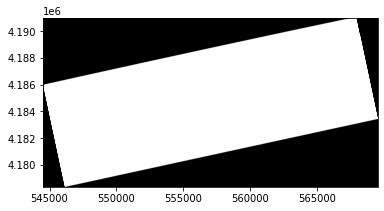

<AxesSubplot:>

In [66]:
from rasterio.plot import show
show(satdat)

### Using a mask to cut raster along boundary

In [62]:
import fiona
# use fiona to open our AOI GeoJSON
with fiona.open('aoi.geojson') as f:
    aoi = [feature["geometry"] for feature in f]

In [63]:
from rasterio.mask import mask
# apply mask with crop=True to crop the resulting raster to the AOI's bounding box
with rasterio.open(image_file) as img:
    clipped, transform = mask(img, aoi, crop=True)
print(clipped.shape)

(4, 2308, 3375)


In [64]:
# use the metadata from our original mosaic
meta = img.meta.copy()

# update metadata with new, clipped mosaic's boundaries
meta.update({"transform": transform,
    "height":clipped.shape[1],
    "width":clipped.shape[2]})

# write the clipped-and-cropped dataset to a new GeoTIFF
with rasterio.open('clipped.tif', 'w', **meta) as dst:
    dst.write(clipped)

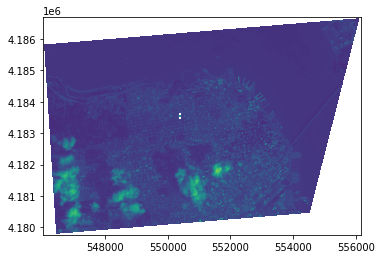

<AxesSubplot:>

In [65]:
clipped_img = rasterio.open("clipped.tif")
show(clipped_img)